# Задание 1

Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Linear считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

Вместо графиков f1 меры сделайте графики для точности и полноты. Пообучайте модель подольше, чтобы посмотреть на то как изменяются метрики.

Напишите короткую функцию для предсказания класса отдельного текста. Возьмите любой новый новостной текст и предскажите его класс. Правильное ли предсказание?

Советы: Начните с небольших сетей и постепенно добавляйте слои и увеличивайте параметры, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц. Помимо уменьшения параметров, вы можете попробовать уменьшить batch size.

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

import pandas as pd
from collections import Counter
from string import punctuation
from tqdm import tqdm

In [2]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip

--2026-01-20 22:26:52--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip [following]
--2026-01-20 22:26:52--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M  --.-KB/s    in 0.06s   

2026-01-2

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')
data.dropna(subset=['topic', 'text'], inplace=True)

In [4]:
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens


vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [6]:
class Dataset(Dataset):
    def __init__(self, word2id, MAX_LEN, texts, targets):
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]
        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [7]:
MAX_LEN = 200
texts = data.text.values

id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}

targets = [label2id[l] for l in data.topic]

In [8]:
train, val, y_train, y_val = train_test_split(texts, targets, test_size=0.05)

In [9]:
training_ds = Dataset(word2id, MAX_LEN, train, y_train)
training_generator = torch.utils.data.DataLoader(training_ds, batch_size=256, shuffle=True)

In [10]:
valid_ds = Dataset(word2id, MAX_LEN, val, y_val)
valid_generator = torch.utils.data.DataLoader(valid_ds, batch_size=256, shuffle=True)

In [18]:
class ClassificationCNN(nn.Module):
    def __init__(self, vocab_size, num_classes, device="cpu", **kwargs):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.build_network(vocab_size, num_classes, **kwargs)
        self.to(device)

    def build_network(self, vocab_size, num_classes, embeddings_dim=100, n_layers=1,
                      window=5, hidden_dim=128, dropout=0.2, use_batch_norm=False, use_pooling=False,
                      pooling_kernel=2, pooling_stride=2, hidden_fc=64, **kwargs):
        self.n_layers = n_layers
        self.use_batch_norm = use_batch_norm
        self.use_pooling = use_pooling
        self.embeddings_dim = embeddings_dim

        if isinstance(hidden_dim, int):
            hidden_dim = ((hidden_dim,),)
        elif isinstance(hidden_dim[0], int):
            hidden_dim = (hidden_dim,)
        self.hidden_dim = list(hidden_dim) * n_layers if len(hidden_dim) == 1 else list(hidden_dim)

        if isinstance(window, int):
            window = ((window,),)
        elif isinstance(window[0], int):
            window = (window,)
        self.window = list(window) * n_layers if len(window) == 1 else list(window)

        self.embedding = nn.Embedding(vocab_size, embeddings_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(p=dropout)

        self.convolutions = nn.ModuleList()
        output_dim = embeddings_dim

        for i in range(n_layers):
            input_dim = output_dim if i > 0 else embeddings_dim
            convolutions = nn.ModuleList()
            layer_output_dim = 0

            for n_out, width in zip(self.hidden_dim[i], self.window[i]):
                convolution = nn.Conv1d(
                    input_dim, n_out, width,
                    padding=width // 2,
                    stride=1,
                    bias=not use_batch_norm
                )
                convolutions.append(convolution)
                layer_output_dim += n_out

            layer_dict = {
                "convolutions": convolutions,
                "activation": nn.ReLU(),
                "dropout": nn.Dropout(p=dropout)
            }

            if use_batch_norm:
                layer_dict["batch_norm"] = nn.BatchNorm1d(layer_output_dim)

            if use_pooling:
                layer_dict["pooling"] = nn.MaxPool1d(
                    kernel_size=pooling_kernel,
                    stride=pooling_stride
                )

            self.convolutions.append(nn.ModuleDict(layer_dict))
            output_dim = layer_output_dim

        self.conv_output_dim = output_dim

        self.fc = nn.Linear(output_dim, hidden_fc)
        self.fc_dropout = nn.Dropout(p=dropout)
        self.fc_1 = nn.Linear(hidden_fc, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

        self._fc_initialized = False

    def _initialize_fc_layer(self, flattened_size):
        self.fc = nn.Linear(flattened_size, self.fc.out_features).to(self.device)
        self._fc_initialized = True

    def forward(self, input_ids, **kwargs):
        input_ids = input_ids.to(self.device)

        embeddings = self.embedding(input_ids)
        embeddings = self.emb_dropout(embeddings)
        conv_inputs = embeddings.permute(0, 2, 1)  # (B, seq_len, emb_dim)

        for layer in self.convolutions:
            convolutions = layer["convolutions"]
            conv_outputs_list = []
            for convolution in convolutions:
                conv_outputs_list.append(convolution(conv_inputs))

            conv_outputs = torch.cat(conv_outputs_list, dim=1)

            if self.use_batch_norm:
                conv_outputs = layer["batch_norm"](conv_outputs)

            conv_outputs = layer["activation"](conv_outputs)

            if self.use_pooling:
                conv_outputs = layer["pooling"](conv_outputs)

            conv_outputs = layer["dropout"](conv_outputs)
            conv_inputs = conv_outputs

        flattened = torch.flatten(conv_outputs, start_dim=1)  # (B, channels * seq_len)

        if not self._fc_initialized:
            self._initialize_fc_layer(flattened.size(1))

        hidden = self.fc(flattened)
        hidden = torch.relu(hidden)
        hidden = self.fc_dropout(hidden)

        logits = self.fc_1(hidden)  # (B, num_classes)
        return logits

In [19]:
model = ClassificationCNN(vocab_size=len(word2id), num_classes=len(label2id), embeddings_dim=100,
                          n_layers=3, hidden_dim=((64, 64, 64), (128, 128, 128), (256, 256, 256)),
                          window=((3, 5, 7), (3, 5, 7), (3, 5, 7)), dropout=0.3, use_pooling=True,
                          pooling_kernel=2, pooling_stride=2, hidden_fc=128, use_batch_norm=True, device='cuda')


optimizer = optim.Adam([{'params': model.fc_1.parameters()},
                        {'params': model.fc.parameters(), 'weight_decay': 0.1},
                         {'params': model.embedding.parameters()},
                          {'params': model.convolutions.parameters()}], lr=0.001)

criterion = nn.CrossEntropyLoss()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
NUM_EPOCHS = 25

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = []
    all_preds = []
    all_labels = []

    for texts, labels in tqdm(iterator, desc="Training"):
        texts, labels = texts.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        log_probs = model(texts)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()

        preds = log_probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        epoch_loss.append(loss.item())

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return np.mean(epoch_loss), precision, recall, f1

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in tqdm(iterator, desc="Evaluating"):
            texts, labels = texts.to('cuda'), labels.to('cuda')
            log_probs = model(texts)
            loss = criterion(log_probs, labels)

            preds = log_probs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            epoch_loss.append(loss.item())

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return np.mean(epoch_loss), precision, recall, f1

history = {'train_prec': [], 'train_rec': [], 'val_prec': [], 'val_rec': []}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_prec, train_rec, train_f1 = train(model, training_generator, optimizer, criterion)
    val_loss, val_prec, val_rec, val_f1 = evaluate(model, valid_generator, criterion)

    history['train_prec'].append(train_prec)
    history['train_rec'].append(train_rec)
    history['val_prec'].append(val_prec)
    history['val_rec'].append(val_rec)

    print(f"Train - Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"Valid - Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")



Epoch 1/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.08it/s]


Train - Prec: 0.1047 | Rec: 0.0901 | F1: 0.0779
Valid - Prec: 0.1362 | Rec: 0.1547 | F1: 0.1263

Epoch 2/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.04it/s]


Train - Prec: 0.2210 | Rec: 0.2067 | F1: 0.1860
Valid - Prec: 0.3035 | Rec: 0.2852 | F1: 0.2713

Epoch 3/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 55.18it/s]


Train - Prec: 0.2915 | Rec: 0.2741 | F1: 0.2651
Valid - Prec: 0.3401 | Rec: 0.3461 | F1: 0.3320

Epoch 4/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.08it/s]


Train - Prec: 0.3781 | Rec: 0.3190 | F1: 0.3147
Valid - Prec: 0.3878 | Rec: 0.3879 | F1: 0.3701

Epoch 5/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.29it/s]


Train - Prec: 0.4055 | Rec: 0.3573 | F1: 0.3610
Valid - Prec: 0.4420 | Rec: 0.4276 | F1: 0.4234

Epoch 6/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.21it/s]


Train - Prec: 0.4573 | Rec: 0.3852 | F1: 0.3927
Valid - Prec: 0.4179 | Rec: 0.4524 | F1: 0.4152

Epoch 7/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.97it/s]


Train - Prec: 0.4793 | Rec: 0.4151 | F1: 0.4258
Valid - Prec: 0.4971 | Rec: 0.4799 | F1: 0.4690

Epoch 8/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 51.43it/s]


Train - Prec: 0.5013 | Rec: 0.4398 | F1: 0.4519
Valid - Prec: 0.5071 | Rec: 0.4916 | F1: 0.4831

Epoch 9/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.46it/s]


Train - Prec: 0.5110 | Rec: 0.4582 | F1: 0.4705
Valid - Prec: 0.5309 | Rec: 0.5187 | F1: 0.5122

Epoch 10/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.98it/s]


Train - Prec: 0.5335 | Rec: 0.4818 | F1: 0.4961
Valid - Prec: 0.5075 | Rec: 0.5378 | F1: 0.5069

Epoch 11/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 52.76it/s]


Train - Prec: 0.5435 | Rec: 0.4950 | F1: 0.5093
Valid - Prec: 0.5438 | Rec: 0.5232 | F1: 0.5217

Epoch 12/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.58it/s]


Train - Prec: 0.5566 | Rec: 0.5083 | F1: 0.5234
Valid - Prec: 0.5748 | Rec: 0.5533 | F1: 0.5521

Epoch 13/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.31it/s]


Train - Prec: 0.5577 | Rec: 0.5212 | F1: 0.5338
Valid - Prec: 0.5329 | Rec: 0.5551 | F1: 0.5316

Epoch 14/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.29it/s]


Train - Prec: 0.5740 | Rec: 0.5381 | F1: 0.5514
Valid - Prec: 0.5605 | Rec: 0.5638 | F1: 0.5455

Epoch 15/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 50.35it/s]


Train - Prec: 0.5828 | Rec: 0.5491 | F1: 0.5618
Valid - Prec: 0.5728 | Rec: 0.5609 | F1: 0.5580

Epoch 16/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.79it/s]


Train - Prec: 0.5884 | Rec: 0.5583 | F1: 0.5704
Valid - Prec: 0.5453 | Rec: 0.5811 | F1: 0.5466

Epoch 17/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.02it/s]


Train - Prec: 0.6436 | Rec: 0.5637 | F1: 0.5754
Valid - Prec: 0.5500 | Rec: 0.5789 | F1: 0.5551

Epoch 18/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.47it/s]


Train - Prec: 0.6544 | Rec: 0.5794 | F1: 0.5904
Valid - Prec: 0.5556 | Rec: 0.5731 | F1: 0.5503

Epoch 19/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 52.54it/s]


Train - Prec: 0.6336 | Rec: 0.5883 | F1: 0.5996
Valid - Prec: 0.5587 | Rec: 0.5894 | F1: 0.5654

Epoch 20/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 52.45it/s]


Train - Prec: 0.6663 | Rec: 0.5982 | F1: 0.6108
Valid - Prec: 0.5505 | Rec: 0.6006 | F1: 0.5599

Epoch 21/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 22.99it/s]


Train - Prec: 0.6842 | Rec: 0.6087 | F1: 0.6217
Valid - Prec: 0.5690 | Rec: 0.6085 | F1: 0.5817

Epoch 22/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.84it/s]


Train - Prec: 0.6744 | Rec: 0.6134 | F1: 0.6234
Valid - Prec: 0.5663 | Rec: 0.5888 | F1: 0.5677

Epoch 23/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 54.04it/s]


Train - Prec: 0.7029 | Rec: 0.6216 | F1: 0.6346
Valid - Prec: 0.5523 | Rec: 0.5985 | F1: 0.5594

Epoch 24/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.43it/s]


Train - Prec: 0.6875 | Rec: 0.6313 | F1: 0.6417
Valid - Prec: 0.5856 | Rec: 0.5910 | F1: 0.5797

Epoch 25/25


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 53.34it/s]

Train - Prec: 0.7914 | Rec: 0.6412 | F1: 0.6581
Valid - Prec: 0.5699 | Rec: 0.5989 | F1: 0.5781


In [22]:
from matplotlib import pyplot as plt

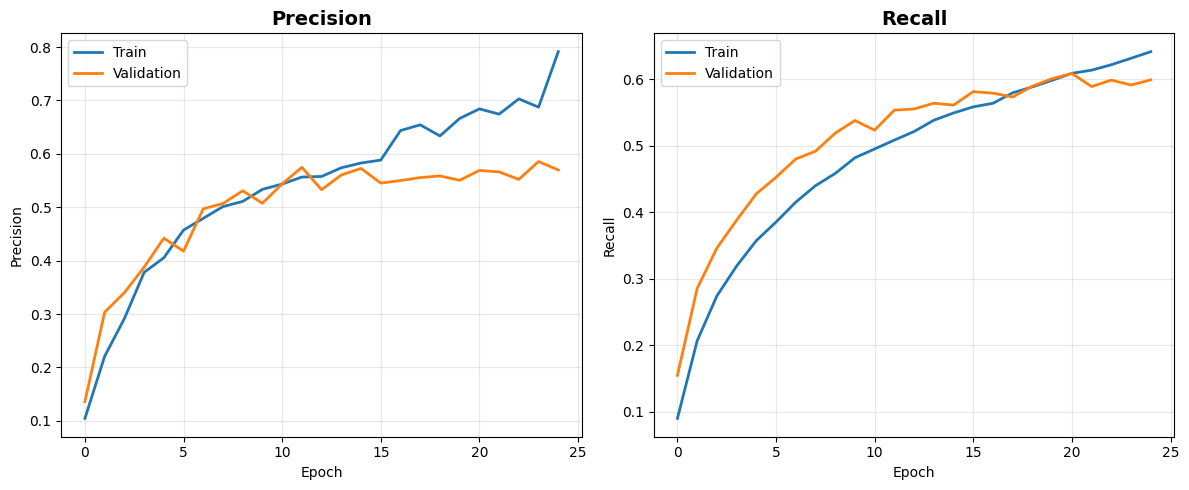

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_prec'], label='Train', linewidth=2)
plt.plot(history['val_prec'], label='Validation', linewidth=2)
plt.title('Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_rec'], label='Train', linewidth=2)
plt.plot(history['val_rec'], label='Validation', linewidth=2)
plt.title('Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
set(data['topic'])

{'69-я параллель',
 'Библиотека',
 'Бизнес',
 'Бывший СССР',
 'Дом',
 'Из жизни',
 'Интернет и СМИ',
 'Крым',
 'Культпросвет ',
 'Культура',
 'Легпром',
 'Мир',
 'Наука и техника',
 'Путешествия',
 'Россия',
 'Силовые структуры',
 'Спорт',
 'Ценности',
 'Экономика'}

In [53]:
texts_data = {'texts': ["""Сбой произошел в работе X (бывший Twitter) 16 января. Об этом свидетельствуют данные сервиса Downdetector.
Массовые жалобы на проблемы в работе социальной сети начали поступать около 18:00 мск.""",
                   """Распространение ИИ-сводок за год сократило на треть переходы на новостные сайты из поисковиков. Издатели ожидают падения трафика еще на 43% в течение трех лет, переходят на платную подписку и берут пример с блогеров""",
                   """Минцифры вновь расширило перечень ресурсов, доступных во время ограничений интернета (так называемый белый список). Обновление опубликовано на сайте ведомства.""",
                   """Россиянку заподозрили в нарушении Теннисной антикоррупционной программы""",
                   """В возрасте 76 лет умер калужский ультрамарафонец Константин Горохов
За полувековую карьеру он пробежал на соревнованиях около 200 тыс. км, что равно пяти кругосветным путешествиям, и установил рекорд в трехсуточном беге""",
                   """Объявленные Трампом новые пошлины в отношении Британии приведут к сокращению ВВП страны на 0,3–0,75%, что может спровоцировать рецессию, поскольку британская экономика растет на 0,2–0,3% в квартал, подсчитали в Capital Economics""",
                   """Общее состояние миллиардеров в 2025 году достигло $18,3 трлн, подсчитал Oxfam. Это почти в два раза больше, чем в 2020-м, и в семь раз — чем в 2000 году. Как менялось состояние самых богатых людей планеты — в инфографике РБК""",
                   """Кафедра аналитической химии Иркутского госуниверситета переименована в кафедру аналитической и фармацевтической химии и получила статус базовой кафедры акционерного общества «Фармасинтез»."""],
         'labels': ['Интернет и СМИ',
                    'Интернет и СМИ',
                    'Интернет и СМИ',
                    'Спорт', 'Спорт',
                    'Экономика', 'Экономика',
                    'Наука и техника']}

In [54]:
def predict_text(text, model, word2id, id2label, max_len=200):
    from string import punctuation

    tokens = text.lower().split()
    tokens = [t.strip(punctuation) for t in tokens if t.strip(punctuation)]
    token_ids = [word2id.get(t, 0) for t in tokens][:max_len]
    token_ids += [0] * (max_len - len(token_ids))

    input_tensor = torch.LongTensor([token_ids]).to('cuda')

    model.eval()
    with torch.no_grad():
        log_probs = model(input_tensor)
        probs = torch.exp(log_probs).squeeze().cpu().numpy()

    predicted_idx = probs.argmax()
    return id2label[predicted_idx]

In [57]:
correct = 0
for i, (text, true_label) in enumerate(zip(texts_data['texts'], texts_data['labels']), 1):
    predicted_class = predict_text(text, model, word2id, id2label)

    is_correct = (predicted_class == true_label)
    correct += is_correct

    print(f"\nТекст {i}:")
    print(f"   {text[:80]}...")
    print(f"   Истинный класс:      {true_label}")
    print(f"   Предсказанный класс: {predicted_class}")
    print(f"   {'ПРАВИЛЬНО' if is_correct else 'НЕПРАВИЛЬНО'}")

accuracy = correct / len(texts_data['texts'])
print(f"\n{correct}/{len(texts_data['texts'])} правильных ({accuracy:.1%})")


Текст 1:
   Сбой произошел в работе X (бывший Twitter) 16 января. Об этом свидетельствуют да...
   Истинный класс:      Интернет и СМИ
   Предсказанный класс: Интернет и СМИ
   ПРАВИЛЬНО

Текст 2:
   Распространение ИИ-сводок за год сократило на треть переходы на новостные сайты ...
   Истинный класс:      Интернет и СМИ
   Предсказанный класс: Интернет и СМИ
   ПРАВИЛЬНО

Текст 3:
   Минцифры вновь расширило перечень ресурсов, доступных во время ограничений интер...
   Истинный класс:      Интернет и СМИ
   Предсказанный класс: Интернет и СМИ
   ПРАВИЛЬНО

Текст 4:
   Россиянку заподозрили в нарушении Теннисной антикоррупционной программы...
   Истинный класс:      Спорт
   Предсказанный класс: Интернет и СМИ
   НЕПРАВИЛЬНО

Текст 5:
   В возрасте 76 лет умер калужский ультрамарафонец Константин Горохов
За полувеков...
   Истинный класс:      Спорт
   Предсказанный класс: Из жизни
   НЕПРАВИЛЬНО

Текст 6:
   Объявленные Трампом новые пошлины в отношении Британии приведут к сокращению